https://www.kaggle.com/debarshichanda/cassava-bitempered-logistic-loss

In [1]:
device = None

## for TPU
## https://www.kaggle.com/abhinand05/vision-transformer-vit-tutorial-baseline
# import os
# if os.path.exists("./torchvision-1.7-cp37-cp37m-linux_x86_64.whl") == False:
#    !curl https://raw.githubusercontent.com/pytorch/xla/master/contrib/scripts/env-setup.py -o pytorch-xla-env-setup.py
#    !python pytorch-xla-env-setup.py --version 1.7
# import torch_xla
# import torch_xla.core.xla_model as xm
# import torch_xla.distributed.xla_multiprocessing as xmp
# import torch_xla.distributed.parallel_loader as pl
# device = xm.xla_device()
# num_workers = 2  # os.cpu_count()  # 4

# for GPU
if device is None:
    import os
    import torch

    device = "cuda" if torch.cuda.is_available() else "cpu"

    if os.getcwd() in ["/kaggle/working", "/content"]:
        num_workers = os.cpu_count()  # 4
    else:
        num_workers = 0

print("device:", device)

device: cuda


In [2]:
#!pip install "../input/pytorchlightning110/pytorch_lightning-1.1.0-py3-none-any.whl"
#
# ROOT_DIR = "../input/cassava-leaf-disease-classification"
# TRAIN_DIR = "../input/cassava-leaf-disease-classification/train_images"
# TEST_DIR = "../input/cassava-leaf-disease-classification/test_images"

import sys
sys.path.append(r"cassava_code")

ROOT_DIR = r"C:\Users\81908\jupyter_notebook\pytorch_lightning_work\kaggle_Cassava\input\cassava-leaf-disease-classification"
TRAIN_DIR = r"C:\Users\81908\jupyter_notebook\pytorch_lightning_work\kaggle_Cassava\input\cassava-leaf-disease-classification\train_images"
TEST_DIR = r"C:\Users\81908\jupyter_notebook\pytorch_lightning_work\kaggle_Cassava\input\cassava-leaf-disease-classification\test_images"

In [3]:
import os
import cv2
import random
import shutil
import pickle
import json

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import models
from torch.utils.data import DataLoader, Dataset
from torch.cuda import amp

from sklearn import metrics
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.utils import class_weight

from tqdm.notebook import tqdm
from collections import defaultdict
import albumentations as A
from albumentations.pytorch import ToTensorV2

import timm

import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.metrics.functional import accuracy

import warnings

warnings.filterwarnings("ignore")

print("pytorch_lightning version:", pl.__version__)

pytorch_lightning version: 1.1.0


In [4]:
import os, shutil
if os.path.exists("lightning_logs/"):
    shutil.rmtree("lightning_logs/")
    os.mkdir("lightning_logs/")

In [5]:
import os
import random
import torch


def set_seed(seed=42):
    """Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY."""
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    os.environ["PYTHONHASHSEED"] = str(seed)

In [6]:
import torch
import torch.nn as nn
from bi_tempered_loss import bi_tempered_logistic_loss


class BiTemperedLoss(nn.Module):
    def __init__(self, t1=0.7, t2=1.3, smoothing=0.0, reduction="mean"):
        super().__init__()
        self.t1 = t1
        self.t2 = t2
        self.reduction = reduction
        self.smoothing = smoothing

    def forward(self, inputs, targets):
        loss = bi_tempered_logistic_loss(
            activations=inputs,
            labels=targets,
            t1=self.t1,
            t2=self.t2,
            label_smoothing=self.smoothing,
        )
        if self.reduction == "sum":
            loss = loss.sum()
        elif self.reduction == "mean":
            loss = loss.mean()

        return loss

In [7]:
# https://amaarora.github.io/2020/08/30/gempool.html
# https://github.com/amaarora/amaarora.github.io/blob/master/nbs/GeM%20Pooling.ipynb
import torch
import torch.nn as nn
import torch.nn.functional as F


class GeM(nn.Module):
    def __init__(self, p=3, eps=1e-6):
        super(GeM, self).__init__()
        self.p = nn.Parameter(torch.ones(1) * p)
        self.eps = eps

    def forward(self, x):
        return self.gem(x, p=self.p, eps=self.eps)

    def gem(self, x, p=3, eps=1e-6):
        return F.avg_pool2d(x.clamp(min=eps).pow(p), (x.size(-2), x.size(-1))).pow(
            1.0 / p
        )

    def __repr__(self):
        return (
            self.__class__.__name__
            + "("
            + "p="
            + "{:.4f}".format(self.p.data.tolist()[0])
            + ", "
            + "eps="
            + str(self.eps)
            + ")"
        )


class GeMNet(nn.Module):
    def __init__(self, features, pool, in_features, n_classes):
        super(GeMNet, self).__init__()
        self.features = nn.Sequential(*features)
        self.fc = nn.Linear(in_features, n_classes)
        self.pool = pool

    def forward(self, x):
        o = self.features(x)
        o = self.pool(o).squeeze(-1).squeeze(-1)
        o = self.fc(o)
        return o

In [8]:
# https://www.kaggle.com/mekhdigakhramanian/pytorch-efficientnet-baseline-inference-tta/data?select=tf_efficientnet_b3_ns_fold_0_0
import torch
import numpy as np


def inference_one_epoch(model, data_loader, device):
    model.eval()

    image_preds_all = []

    for step, batch in enumerate(data_loader):

        imgs = batch["x"].to(device).float()
        model = model.to(device)

        image_preds = model(imgs)
        image_preds_all += [torch.softmax(image_preds, 1).detach().cpu().numpy()]

    image_preds_all = np.concatenate(image_preds_all, axis=0)
    return image_preds_all

# params

In [9]:
class Config:
    def __init__(self):
        self.seeds = [42]
        self.n_classes = 5
        self.max_epochs = 10
        self.patience = 10
        self.n_splits = 5
        self.shuffle = True
        #self.batch_size = 16
        #self.accumulate_grad_batches = 1
        self.batch_size = 4
        self.accumulate_grad_batches = 4
        self.height = 512
        self.width = 512
        self.arch = "tf_efficientnet_b4_ns"
        self.opt = "adam"
        self.lr_scheduler = "CosineAnnealingWarmRestarts"
        self.T_max = 10
        self.T_0 = 10
        self.lr = 1e-4
        self.min_lr = 1e-6
        self.weight_decay = 1e-6
        self.smoothing = 0.2
        self.train_loss_name = "BiTemperedLoss"
        self.t1 = 0.8
        self.t2 = 1.4
        self.gem_p = 0
        self.mix_decision_th = 0.5
        self.is_cutmix = False
        self.is_fmix = False
        self.is_snapmix = False
        self.mix_alpha = 1.0
        self.is_over_sample = False
        self.is_under_sample = False
        self.n_over = 0
        self.is_only_first_fold = False
        self.n_tta = 5
        self.device = device
        self.num_workers = num_workers
CFG = Config()

# Data

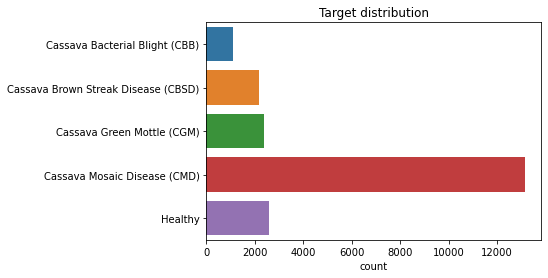

{0: 'Cassava Bacterial Blight (CBB)', 1: 'Cassava Brown Streak Disease (CBSD)', 2: 'Cassava Green Mottle (CGM)', 3: 'Cassava Mosaic Disease (CMD)', 4: 'Healthy'}


In [10]:
df = pd.read_csv(f"{ROOT_DIR}/train.csv")
df["file_path"] = f"{ROOT_DIR}/train_images/" + df["image_id"]

with open(f"{ROOT_DIR}/label_num_to_disease_map.json", "r") as f:
    name_mapping = json.load(f)

name_mapping = {int(k): v for k, v in name_mapping.items()}

sns.countplot(y=sorted(df["label"].map(name_mapping)), orient="v")
plt.title("Target distribution")
plt.show()

print(name_mapping)


#DEBUG = True
DEBUG = False
if DEBUG:
    df = df.iloc[:100,]
    CFG.n_splits = 2
    CFG.max_epochs = 6
    CFG.height, CFG.width = 64, 64
    
    #CFG.is_only_first_fold = True
    CFG.is_only_first_fold = False
    
    print("DEBUG:", DEBUG)

In [11]:
data_transforms = {
    "train": A.Compose(
        [
            A.RandomResizedCrop(CFG.height, CFG.width),
            A.Transpose(p=0.5),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.ShiftScaleRotate(p=0.5),
            A.HueSaturationValue(
                hue_shift_limit=0.2, sat_shift_limit=0.2, val_shift_limit=0.2, p=0.5
            ),
            A.RandomBrightnessContrast(
                brightness_limit=(-0.1, 0.1), contrast_limit=(-0.1, 0.1), p=0.5
            ),
            A.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
                max_pixel_value=255.0,
                p=1.0,
            ),
            A.CoarseDropout(p=0.5),
            A.Cutout(p=0.5),
            ToTensorV2(),
        ],
        p=1.0,
    ),
    "valid": A.Compose(
        [
            A.CenterCrop(CFG.height, CFG.width, p=1.0),
            A.Resize(CFG.height, CFG.width),
            A.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
                max_pixel_value=255.0,
                p=1.0,
            ),
            ToTensorV2(),
        ],
        p=1.0,
    ),
    "test": A.Compose(
        [
            A.RandomResizedCrop(CFG.height, CFG.width),
            A.Transpose(p=0.5),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.ShiftScaleRotate(p=0.5),
            A.HueSaturationValue(
                hue_shift_limit=0.2, sat_shift_limit=0.2, val_shift_limit=0.2, p=0.5
            ),
            A.RandomBrightnessContrast(
                brightness_limit=(-0.1, 0.1), contrast_limit=(-0.1, 0.1), p=0.5
            ),
            A.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
                max_pixel_value=255.0,
                p=1.0,
            ),
            ToTensorV2(),
        ],
        p=1.0,
    ),
}

# Dataset, Lightning Data Module

In [12]:
class CassavaDataset(Dataset):
    def __init__(self, df: pd.DataFrame, train: bool = True, transforms=None):
        self.df = df
        self.train = train
        self.transforms = transforms

    def __getitem__(self, index):
        im_path = self.df.iloc[index]["file_path"]
        x = cv2.imread(im_path, cv2.IMREAD_COLOR)
        x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)

        if self.transforms:
            x = self.transforms(image=x)["image"]

        if self.train:
            y = self.df.iloc[index]["label"]
            return {"x": x, "y": y}
        else:
            return {"x": x}

    def __len__(self):
        return len(self.df)


class CassavaDataModule(pl.LightningDataModule):
    def __init__(
        self, train_df, valid_df, data_transforms, CFG,
    ):
        super().__init__()
        self.train_df = train_df
        self.valid_df = valid_df

    def prepare_data(self):
        pass

    def setup(self, stage=None):
        self.train_dataset = CassavaDataset(
            self.train_df, train=True, transforms=data_transforms["train"]
        )

        self.valid_dataset = CassavaDataset(
            self.valid_df, train=True, transforms=data_transforms["valid"]
        )

        self.valid_tta_dataset = CassavaDataset(
            self.valid_df, train=True, transforms=data_transforms["test"]
        )  # test setのTTA条件

    def train_dataloader(self):
        return DataLoader(
            self.train_dataset,
            batch_size=CFG.batch_size,
            num_workers=CFG.num_workers,
            shuffle=True,
            drop_last=True,
        )

    def val_dataloader(self):
        return DataLoader(
            self.valid_dataset,
            batch_size=CFG.batch_size,
            num_workers=CFG.num_workers,
            shuffle=False,
        )

    def val_tta_dataloader(self):
        return DataLoader(
            self.valid_tta_dataset,
            batch_size=CFG.batch_size,
            num_workers=CFG.num_workers,
            shuffle=False,
        )

# LightningModule

In [13]:
class CassavaLite(pl.LightningModule):
    def __init__(self, CFG):
        super().__init__()

        self.save_hyperparameters(CFG.__dict__)

        self.use_amp = True  # apex amp を有効にする(16-bit mixed precision) https://pytorch-lightning.readthedocs.io/en/stable/lightning_module.html

        self.net = timm.create_model(CFG.arch, pretrained=True)

        if "eff" in CFG.arch:
            self.net.classifier = nn.Linear(
                self.net.classifier.in_features, CFG.n_classes
            )
            if CFG.gem_p > 0.0:
                self.net = GeMNet(
                    list(self.net.children())[:-2],
                    GeM(p=CFG.gem_p),
                    self.net.classifier.in_features,
                    CFG.n_classes,
                )
            self.feat_net = nn.Sequential(*list(self.net.children())[:-2])

        elif "rexnet" in CFG.arch:
            self.net.head.fc = nn.Linear(self.net.head.fc.in_features, CFG.n_classes)
            if CFG.gem_p > 0.0:
                self.net = GeMNet(
                    list(self.net.children())[:-1],
                    GeM(p=CFG.gem_p),
                    self.net.head.fc.in_features,
                    CFG.n_classes,
                )
            self.feat_net = nn.Sequential(*list(self.net.children())[:-1])

        elif "vit" in CFG.arch:
            self.net.head = nn.Linear(self.net.head.in_features, CFG.n_classes)
            self.feat_net = nn.Sequential(*list(self.net.children())[:-1])

        else:
            self.net.fc = nn.Linear(self.net.fc.in_features, CFG.n_classes)
            if CFG.gem_p > 0.0:
                self.net = GeMNet(
                    list(self.net.children())[:-2],
                    GeM(p=CFG.gem_p),
                    self.net.fc.in_features,
                    CFG.n_classes,
                )
            self.feat_net = nn.Sequential(
                *list(self.net.children())[:-2]
            )  # global_poolとfc層除く

    def forward(self, x):
        out = self.net(x)
        return out

    def feat_forward(self, x):
        """全結合層の直前の予測値取得用"""
        feat = self.feat_net(x)
        return feat.detach()  # 「detach()」はTensor型から勾配情報を抜いたものを取得

    def configure_optimizers(self):
        if CFG.opt == "adam":
            optimizer = torch.optim.Adam(
                self.parameters(),
                lr=CFG.lr,
                weight_decay=CFG.weight_decay,
                amsgrad=False,
            )
        elif CFG.opt == "adabelief":
            optimizer = AdaBelief(
                self.parameters(), lr=CFG.lr, weight_decay=CFG.weight_decay
            )
        elif CFG.opt == "radam":
            optimizer = torch_optimizer.RAdam(
                self.parameters(), lr=CFG.lr, weight_decay=CFG.weight_decay
            )
        else:
            optimizer = torch.optim.AdamW(
                self.parameters(), lr=CFG.lr, weight_decay=CFG.weight_decay
            )

        if CFG.lr_scheduler == "CosineAnnealingLR":
            scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
                optimizer, T_max=CFG.T_max, eta_min=CFG.min_lr
            )
        elif CFG.lr_scheduler == "CosineAnnealingWarmRestarts":
            scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
                optimizer, T_0=CFG.T_max, T_mult=1, eta_min=CFG.min_lr
            )
        elif CFG.lr_scheduler == "CosineAnnealingWarmUpRestarts":
            scheduler = _CosineAnnealingWarmupRestarts(
                optimizer,
                first_cycle_steps=CFG.num_epochs,
                max_lr=CFG.lr,
                min_lr=CFG.min_lr,
                warmup_steps=1,
            )
        else:
            scheduler = torch.optim.lr_scheduler.StepLR(
                optimizer, step_size=2, gamma=0.1
            )

        return [optimizer], [scheduler]

    def training_step(self, batch, batch_idx):
        x, y = batch["x"], batch["y"]

        if CFG.train_loss_name == "SmoothCrossEntropyLoss":
            loss_fn = SmoothCrossEntropyLoss(smoothing=CFG.smoothing).to(CFG.device)
        elif CFG.train_loss_name == "FocalCosineLoss":
            loss_fn = FocalCosineLoss(smoothing=CFG.smoothing).to(CFG.device)
        elif CFG.train_loss_name == "BiTemperedLoss":
            loss_fn = BiTemperedLoss(t1=CFG.t1, t2=CFG.t2, smoothing=CFG.smoothing).to(
                CFG.device
            )
        elif CFG.train_loss_name == "ElrLoss":
            loss_fn = ElrLoss(num_classes=CFG.n_classes).to(CFG.device)
        else:
            loss_fn = nn.CrossEntropyLoss().to(CFG.device)

        # cutmix/fmix/snapmix
        mix_decision = np.random.rand()
        if mix_decision < CFG.mix_decision_th:
            if CFG.is_cutmix:
                x, y_mixs = cutmix(x, y.long(), CFG.mix_alpha)
                y_hat = self(x.float())
                loss = loss_fn(y_hat, y_mixs[0]) * y_mixs[2] + loss_fn(
                    y_hat, y_mixs[1]
                ) * (1.0 - y_mixs[2])

            elif CFG.is_fmix:
                x, y_mixs = fmix(
                    x,
                    y.long(),
                    alpha=CFG.mix_alpha,
                    decay_power=5.0,
                    shape=(CFG.height, CFG.width),
                )
                y_hat = self(x.float())
                loss = loss_fn(y_hat, y_mixs[0]) * y_mixs[2] + loss_fn(
                    y_hat, y_mixs[1]
                ) * (1.0 - y_mixs[2])

            elif CFG.is_snapmix:
                x, y_mixs = snapmix(x, y.long(), model=self, alpha=CFG.mix_alpha)
                y_hat = self(x.float())
                snapmix_loss = SnapMixLoss().to(CFG.device)
                loss = snapmix_loss(
                    loss_fn, y_hat, y_mixs[0], y_mixs[1], y_mixs[2], y_mixs[3]
                )

            else:
                y_hat = self(x.float())
                loss = loss_fn(y_hat, y)

        else:
            y_hat = self(x.float())
            loss = loss_fn(y_hat, y)

        acc = accuracy(y_hat, y)
        self.log(
            "train_acc", acc, on_step=False, on_epoch=True, prog_bar=True, logger=True
        )
        self.log(
            "train_loss", loss, on_step=False, on_epoch=True, prog_bar=True, logger=True
        )
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch["x"], batch["y"]
        y_hat = self(x)
        loss = nn.CrossEntropyLoss()(y_hat, y)
        acc = accuracy(y_hat, y)
        self.log("val_acc", acc, prog_bar=True, logger=True),
        self.log("val_loss", loss, prog_bar=True, logger=True)


print(CassavaLite(CFG))

for i, param in enumerate(CassavaLite(CFG).parameters()):
    print(i, f"requires_grad: {param.requires_grad}")


CassavaLite(
  (net): EfficientNet(
    (conv_stem): Conv2dSame(3, 48, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn1): BatchNorm2d(48, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (act1): SwishMe()
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=48, bias=False)
          (bn1): BatchNorm2d(48, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
          (act1): SwishMe()
          (se): SqueezeExcite(
            (conv_reduce): Conv2d(48, 12, kernel_size=(1, 1), stride=(1, 1))
            (act1): SwishMe()
            (conv_expand): Conv2d(12, 48, kernel_size=(1, 1), stride=(1, 1))
          )
          (conv_pw): Conv2d(48, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn2): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
          (act2): Identity()
        )
  

0 requires_grad: True
1 requires_grad: True
2 requires_grad: True
3 requires_grad: True
4 requires_grad: True
5 requires_grad: True
6 requires_grad: True
7 requires_grad: True
8 requires_grad: True
9 requires_grad: True
10 requires_grad: True
11 requires_grad: True
12 requires_grad: True
13 requires_grad: True
14 requires_grad: True
15 requires_grad: True
16 requires_grad: True
17 requires_grad: True
18 requires_grad: True
19 requires_grad: True
20 requires_grad: True
21 requires_grad: True
22 requires_grad: True
23 requires_grad: True
24 requires_grad: True
25 requires_grad: True
26 requires_grad: True
27 requires_grad: True
28 requires_grad: True
29 requires_grad: True
30 requires_grad: True
31 requires_grad: True
32 requires_grad: True
33 requires_grad: True
34 requires_grad: True
35 requires_grad: True
36 requires_grad: True
37 requires_grad: True
38 requires_grad: True
39 requires_grad: True
40 requires_grad: True
41 requires_grad: True
42 requires_grad: True
43 requires_grad: Tru

# Train

In [14]:
%%time
Y_pred = pd.DataFrame(
    np.zeros((df.shape[0], CFG.n_classes)),
    columns=name_mapping.values(),
    index=df.index,
)
Y_pred_tta = Y_pred.copy()

for i in CFG.seeds:
    set_seed(seed=i)

    cv = StratifiedKFold(n_splits=CFG.n_splits, shuffle=CFG.shuffle, random_state=i)

    for j, (train_idx, valid_idx) in enumerate(cv.split(df, df["label"])):

        if CFG.is_only_first_fold:
            if j > 0:
                break

        train_df, valid_df = df.iloc[train_idx], df.iloc[valid_idx]

        if CFG.is_over_sample:
            train_df = imblearn_over_sampling(
                train_df, train_df["label"], random_state=i, is_plot=False
            )
        elif CFG.is_under_sample:
            train_df = imblearn_under_sampling(
                train_df, train_df["label"], random_state=i, is_plot=False
            )
        elif CFG.n_over > 0:
            # マイナークラスのみover sampling
            train_df = minor_class_over_sample(
                train_df, n_over=CFG.n_over, is_plot=False
            )

        dm = CassavaDataModule(train_df, valid_df, data_transforms, CFG)

        trainer_params = {"max_epochs": CFG.max_epochs}
        trainer_params["accumulate_grad_batches"] = CFG.accumulate_grad_batches  # 勾配をnバッチ分溜めてから誤差逆伝播
        early_stopping = EarlyStopping("val_loss", patience=CFG.patience)
        model_checkpoint = ModelCheckpoint(
            monitor="val_loss", save_top_k=2, mode="min",
        )
        trainer_params["callbacks"] = [model_checkpoint, early_stopping]

        if device == "cuda":
            trainer_params["gpus"] = 1
        if type(device) != str:
            trainer_params["tpu_cores"] = 1  # xm.xrt_world_size()
            trainer_params["precision"] = 16

        trainer = pl.Trainer(**trainer_params)
        trainer.fit(CassavaLite(CFG), dm)

        # ModelCheckpointでfilename指定するとバージョンidつくので別途コピー作る
        shutil.copy(
            trainer.checkpoint_callback.best_model_path, f"model_seed_{i}_fold_{j}.ckpt"
        )

        # ---------- val predict ---------
        pretrained_model = CassavaLite(CFG).load_from_checkpoint(
            trainer.checkpoint_callback.best_model_path, CFG=CFG, 
        )
        with torch.no_grad():  # 勾配計算を無効してメモリ効率化
            Y_pred.iloc[valid_idx] += inference_one_epoch(
                pretrained_model, dm.val_dataloader(), device
            )
        print(
            f"fold {j} validation loss = {metrics.log_loss(valid_df.label.values, Y_pred.iloc[valid_idx])}"
        )
        print(
            f"fold {j} validation accuracy = {(valid_df.label.values==np.argmax(Y_pred.iloc[valid_idx].values, axis=1)).mean()}\n"
        )

        with torch.no_grad():
            for _ in range(CFG.n_tta):
                Y_pred_tta.iloc[valid_idx] += (
                    inference_one_epoch(
                        pretrained_model, dm.val_tta_dataloader(), device
                    )
                    / CFG.n_tta
                )
        print(
            f"fold {j} validation tta loss = {metrics.log_loss(valid_df.label.values, Y_pred_tta.iloc[valid_idx])}"
        )
        print(
            f"fold {j} validation tta accuracy = {(valid_df.label.values==np.argmax(Y_pred_tta.iloc[valid_idx].values, axis=1)).mean()}"
        )

        print("-" * 100)

        del pretrained_model
        torch.cuda.empty_cache()  # 空いているキャッシュメモリを解放してGPUメモリの断片化を減らす

pickle.dump(Y_pred, open("Y_pred.pkl", "wb"))
pickle.dump(Y_pred_tta, open("Y_pred_tta.pkl", "wb"))

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type         | Params
------------------------------------------
0 | net      | EfficientNet | 17.6 M
1 | feat_net | Sequential   | 17.5 M
------------------------------------------
17.6 M    Trainable params
0         Non-trainable params
17.6 M    Total params



fold 0 validation loss = 0.3365696086416649
fold 0 validation accuracy = 0.8913551401869159



GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


fold 0 validation tta loss = 0.32978636048109494
fold 0 validation tta accuracy = 0.8974299065420561
----------------------------------------------------------------------------------------------------



  | Name     | Type         | Params
------------------------------------------
0 | net      | EfficientNet | 17.6 M
1 | feat_net | Sequential   | 17.5 M
------------------------------------------
17.6 M    Trainable params
0         Non-trainable params
17.6 M    Total params



fold 1 validation loss = 0.3221924909235592
fold 1 validation accuracy = 0.8974299065420561



GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


fold 1 validation tta loss = 0.31353870944416506
fold 1 validation tta accuracy = 0.9
----------------------------------------------------------------------------------------------------



  | Name     | Type         | Params
------------------------------------------
0 | net      | EfficientNet | 17.6 M
1 | feat_net | Sequential   | 17.5 M
------------------------------------------
17.6 M    Trainable params
0         Non-trainable params
17.6 M    Total params



fold 2 validation loss = 0.36328393574705714
fold 2 validation accuracy = 0.8878242580042066



GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


fold 2 validation tta loss = 0.33022466283247986
fold 2 validation tta accuracy = 0.8927319467165226
----------------------------------------------------------------------------------------------------



  | Name     | Type         | Params
------------------------------------------
0 | net      | EfficientNet | 17.6 M
1 | feat_net | Sequential   | 17.5 M
------------------------------------------
17.6 M    Trainable params
0         Non-trainable params
17.6 M    Total params



fold 3 validation loss = 0.35460089060058125
fold 3 validation accuracy = 0.8903949520916102



GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


fold 3 validation tta loss = 0.3368851749775804
fold 3 validation tta accuracy = 0.8924982472540313
----------------------------------------------------------------------------------------------------



  | Name     | Type         | Params
------------------------------------------
0 | net      | EfficientNet | 17.6 M
1 | feat_net | Sequential   | 17.5 M
------------------------------------------
17.6 M    Trainable params
0         Non-trainable params
17.6 M    Total params



fold 4 validation loss = 0.37264527681811926
fold 4 validation accuracy = 0.8850198644543118

fold 4 validation tta loss = 0.3344700642800428
fold 4 validation tta accuracy = 0.8903949520916102
----------------------------------------------------------------------------------------------------
Wall time: 17h 32min 27s


In [15]:
# pickle.load(open("Y_pred.pkl", 'rb'))
pickle.load(open("Y_pred_tta.pkl", "rb"))

,Cassava Bacterial Blight (CBB),Cassava Brown Streak Disease (CBSD),Cassava Green Mottle (CGM),Cassava Mosaic Disease (CMD),Healthy
0,0.600637,0.097856,0.189228,0.011666,0.100614
1,0.002745,0.005584,0.008898,0.977502,0.005271
2,0.014369,0.136917,0.014257,0.104424,0.730033
3,0.013644,0.882966,0.014762,0.069949,0.018680
4,0.002157,0.012757,0.001865,0.972070,0.011151
...,...,...,...,...,...
21392,0.004294,0.004454,0.007813,0.976896,0.006543
21393,0.004484,0.005566,0.010301,0.974546,0.005103
21394,0.037985,0.816822,0.028943,0.080945,0.035304
21395,0.021880,0.010397,0.004274,0.037776,0.925672


In [16]:
oof_preds_df = pd.DataFrame(
    {
        "target": df["label"],
        "prediction": Y_pred.values.argmax(1),
        "logit": Y_pred.values.max(1),
        "file_path": df["file_path"],
    }
)
oof_preds_df.to_csv("oof_preds_df.csv", index=False)
# display(oof_preds_df)


oof_preds_df = pd.DataFrame(
    {
        "target": df["label"],
        "prediction": Y_pred_tta.values.argmax(1),
        "logit": Y_pred_tta.values.max(1),
        "file_path": df["file_path"],
    }
)
oof_preds_df.to_csv("oof_preds_df_tta.csv", index=False)
display(oof_preds_df)

,target,prediction,logit,file_path
0,0,0,0.600637,C:\Users\81908\jupyter_notebook\pytorch_lightn...
1,3,3,0.977502,C:\Users\81908\jupyter_notebook\pytorch_lightn...
2,1,4,0.730033,C:\Users\81908\jupyter_notebook\pytorch_lightn...
3,1,1,0.882966,C:\Users\81908\jupyter_notebook\pytorch_lightn...
4,3,3,0.972070,C:\Users\81908\jupyter_notebook\pytorch_lightn...
...,...,...,...,...
21392,3,3,0.976896,C:\Users\81908\jupyter_notebook\pytorch_lightn...
21393,3,3,0.974546,C:\Users\81908\jupyter_notebook\pytorch_lightn...
21394,1,1,0.816822,C:\Users\81908\jupyter_notebook\pytorch_lightn...
21395,4,4,0.925672,C:\Users\81908\jupyter_notebook\pytorch_lightn...


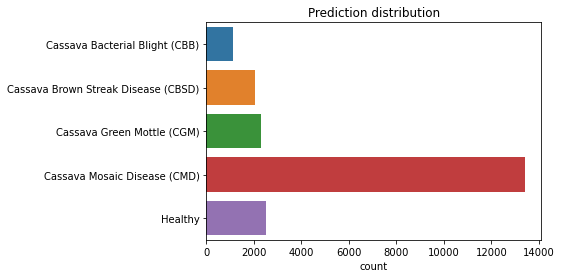

In [17]:
sns.countplot(y=sorted(oof_preds_df["prediction"].map(name_mapping)), orient="v")
plt.title("Prediction distribution")
plt.show()

In [18]:
print(metrics.classification_report(oof_preds_df["target"], oof_preds_df["prediction"]))

              precision    recall  f1-score   support

           0       0.67      0.68      0.68      1087
           1       0.86      0.80      0.83      2189
           2       0.83      0.81      0.82      2386
           3       0.96      0.97      0.96     13158
           4       0.76      0.74      0.75      2577

    accuracy                           0.89     21397
   macro avg       0.81      0.80      0.81     21397
weighted avg       0.89      0.89      0.89     21397



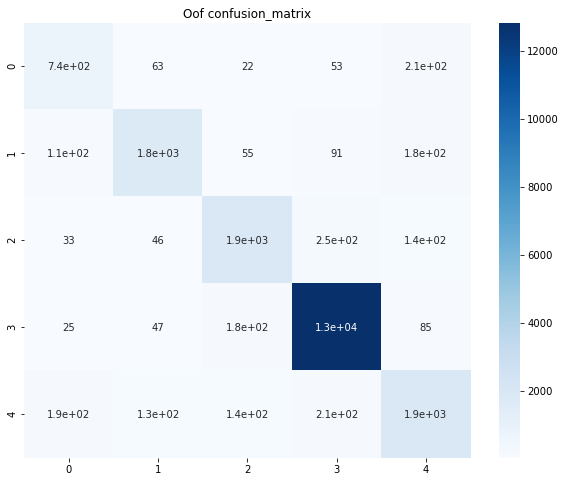

In [19]:
plt.figure(figsize=(10, 8))
sns.heatmap(
    metrics.confusion_matrix(oof_preds_df["target"], oof_preds_df["prediction"]),
    annot=True,
    cmap="Blues",
)
plt.title("Oof confusion_matrix")
plt.show()

In [20]:
#%load_ext tensorboard
#%tensorboard --logdir ./lightning_logs